## Week 6 Lab exercises

In this week we will practise linear algebra using numpy and sympy, and look at the solution of linear ODEs with implicit methods.

In [1]:
# first we import the libraries we need
import numpy as np
import numpy.matlib
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

# The following lines makes the plots appear inline in the notebook
%matplotlib inline

### ACTIVITY 1: 

I have written a class below for integrating linear equations that implements the (explicit) forward Euler method using matrix methods. Update it to include the (implicit) backwards Euler method. Be sure to add in asserts to sense check what the class is doing.

The class is applied to the system we saw in the lectures:

$\dot x = 998 x + 1998y \quad x(0) = 1$

$\dot y = -999 x - 1999y \quad y(0) = 0$

which can also be written as

$\frac{d}{dt}\begin{bmatrix}
x \\
y
\end{bmatrix} = \begin{bmatrix}
998 & 1998\\
-999 & -1999
\end{bmatrix} \begin{bmatrix}
x \\
y
\end{bmatrix}$

Determine:

1. What is the maximum step size we can take while still keeping the Forward Euler method _stable_?

*-> It starts to stabilise around h=1/500*

2. Is this consistent with the bounds we saw in the lecture? 

*-> The bound should be $h_min = 2/\lambda_{max}$ so this seems consistent*

3. What step size do we need to take in order to keep the Backward Euler method _stable_?

*-> Any step size is stable!*

4. Is this consistent with the bounds we saw in the lecture?

*Yes*

5. What step size do we need to take in order to render the Backward Euler method _accurate_?

*It seems like about 100 steps is needed to get something reasonable at the start. So whilst the method is stable, it still needs a good number of points in order to be accurate.*

In [2]:
# LinearIntegrator class

class LinearIntegrator :

    """
    Contains explicit and implicit methods to integrate ODEs
    
    attributes: the function to calculate the gradient dydt, max_time, 
                N_time_steps, method
                
    methods: calculate_solution, plot_solution
    
    """
    integration_methods = ["ForwardEuler", "BackwardEuler"]
    
    # constructor function
    def __init__(self, a_C_matrix, a_max_time=0, a_N_time_steps=0, a_method = "ForwardEuler"):
        
        self.C_matrix = a_C_matrix # Note that we are passing in a function, this is ok in python
        self._method = a_method
        assert self._method in self.integration_methods, 'chosen integration method not implemented'
        
        # Make these private - restrict getting and setting as below
        self._dimension = np.size(self.C_matrix, 0)
        self._max_time = a_max_time
        self._N_time_steps = a_N_time_steps
        
        # Derived from the values above
        self._delta_t = self.max_time / self.N_time_steps
        self._t_solution = np.linspace(0.0, max_time, N_time_steps+1)
        self._y_solution = np.zeros([self.N_time_steps+1, self._dimension])

    # Enables the user to get the y solution
    @property
    def y_solution(self):
        return self._y_solution

    # Enables the user to get the t solution
    @property
    def t_solution(self):
        return self._t_solution
    
    @property
    def max_time(self):
        return self._max_time

    @property
    def N_time_steps(self):
        return self._N_time_steps

    @property
    def method(self):
        return self._method
    
    # Enables user to set the method
    @method.setter
    def method(self, value):    
        self._method = value
        assert self._method in self.integration_methods, 'chosen integration method not implemented'

    # Enables the user to reset the max time
    @max_time.setter
    def max_time(self, value):
        self._max_time = value
        self._delta_t = self.max_time / self.N_time_steps
        self._t_solution = np.linspace(0.0, self.max_time, self.N_time_steps+1)
        self._y_solution = np.zeros([self.N_time_steps+1,self._dimension])
        
    # Enables the user to reset the number of time steps
    @N_time_steps.setter
    def N_time_steps(self, value):
        self._N_time_steps = value
        self._delta_t = self.max_time / self.N_time_steps
        self._t_solution = np.linspace(0.0, self.max_time, self.N_time_steps+1)
        self._y_solution = np.zeros([self.N_time_steps+1,self._dimension])

    def calculate_solution(self, y0) :
        if (self._method == "ForwardEuler") :
            self.integrate_using_forward_Euler(y0)
        elif (self._method == "BackwardEuler") :
            self.integrate_using_backward_Euler(y0)
        else :
            assert False, 'integration method not implemented'
            
    def plot_solution(self, max_i = -1) :
        if(max_i == -1) :
            max_i = self._dimension
            
        plt.xlabel("t", fontsize=16)
        plt.ylabel("y", fontsize=16)
        for i in np.arange(max_i) :
            plt.plot(self._t_solution, self._y_solution[:,i], '-', 
                     label=self._method + " for the " + str(i) + "th variable "+ 
                             " delta_t is " + str(self._delta_t))
        plt.legend(bbox_to_anchor=(1.05, 0.5))

    def integrate_using_forward_Euler(self, y0) :
        
        h = self._delta_t
        for itime, time in enumerate(self.t_solution) :
            if itime == 0 :
                self._y_solution[itime,:] = y0
            else :
                I_matrix = np.eye(self._dimension)
                I_minus_hC = I_matrix - h * self.C_matrix
                yold = np.matrix(self._y_solution[itime-1, :])
                # Need to be a bit careful with the shapes here
                yold = yold.transpose()
                ynew = I_minus_hC * yold
                ynew = ynew.transpose()
                self._y_solution[itime,:] = ynew

    def integrate_using_backward_Euler(self, y0) :
        h = self._delta_t
        for itime, time in enumerate(self.t_solution) :
            if itime == 0 :
                self._y_solution[itime,:] = y0
            else :
                I_matrix = np.eye(self._dimension)
                I_plus_hC = I_matrix + h * self.C_matrix
                I_plus_hC_inv = np.linalg.inv(I_plus_hC) # inverse matrix
                yold = np.matrix(self._y_solution[itime-1, :])
                # Need to be a bit careful with the shapes here
                yold = yold.transpose()
                ynew = I_plus_hC_inv * yold
                ynew = ynew.transpose()
                self._y_solution[itime,:] = ynew


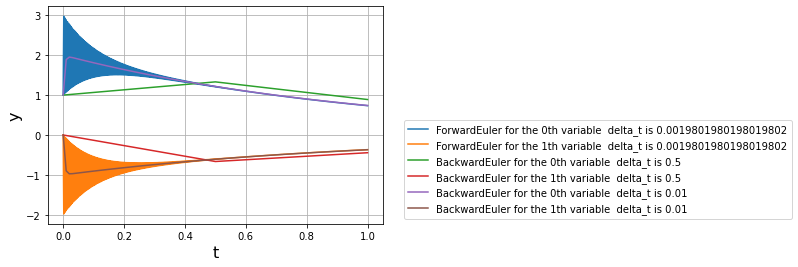

In [3]:
# How to use the class - example from the lecture
C_matrix = np.matrix([[-998, -1998], [999, 1999]]) # Minus the one in the equations
y0 = np.array([1.0, 0.0])
max_time = 1.0
N_time_steps = 505 # This is the minimum for stability

# Define an object of the class
stiff_problem_integrator = LinearIntegrator(C_matrix, max_time, 
                                         N_time_steps, "ForwardEuler")

# Find and plot the solution
stiff_problem_integrator.calculate_solution(y0)
stiff_problem_integrator.plot_solution()

# Update integrator and num points to a smaller value
stiff_problem_integrator.N_time_steps = 2
stiff_problem_integrator.method = "BackwardEuler"
stiff_problem_integrator.calculate_solution(y0)
stiff_problem_integrator.plot_solution()

# Stable but still not very accurate, so increase points again
stiff_problem_integrator.N_time_steps = 100
stiff_problem_integrator.calculate_solution(y0)
stiff_problem_integrator.plot_solution()
plt.grid()

### ACTIVITY 2:
    
Now apply the integrator to the following coupled, second order harmonic oscillator system.

_HINT_ You first need to think carefully about what dimension this needs to be, and how to cast it into first order matrix form:

${\begin{aligned}
m_1{\ddot {x}}_{1}&=-kx_{1}+k(x_{2}-x_{1})=-2kx_{1}+kx_{2}
\\
m_2{\ddot {x}}_{2}&=-kx_{2}+k(x_{1}-x_{2})=-2kx_{2}+kx_{1}
\end{aligned}}$

where $k$ is the spring constant and $m_1$ and $m_2$ are the mass of the oscillators. Set the initial conditions as 

$x_1 = 1 \quad \dot{x}_1 = 0$

$x_2 = 0 \quad \dot{x}_2 = 2$

Set $k=1$ and $m_1 = 0.1$ and $m_2 = 10$

SOLUTION:

In first order form the equations are:

${\begin{aligned}
{\dot {x}}_{1} &= v_1
\\
{\dot {x}}_{2} &= v_2
\\
{\dot {v}}_{1} &= k/m_1 (-2 x_{1} + x_{2})
\\
{\dot {v}}_{2} &= k/m_2 (-2 x_{2} + x_{1})
\end{aligned}}$

So the matrix is

$\frac{d}{dt}\begin{bmatrix}
x_1 \\
x_2 \\
v_1 \\
v_2 \\
\end{bmatrix} = \begin{bmatrix}
0 & 0 & 1 & 0 \\
0 & 0 & 0 & 1 \\
-2k/m_1 & k/m_1 & 0 & 0 \\
k/m_2 & -2k/m_2 & 0 & 0
\end{bmatrix} \begin{bmatrix}
x_1 \\
x_2 \\
v_1 \\
v_2 \\
\end{bmatrix}$

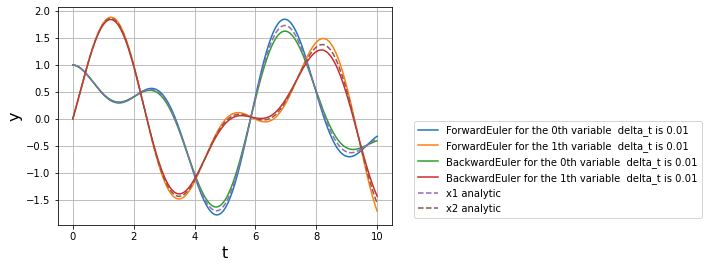

In [4]:
# Integrator for the coupled harmonic oscillator

# Oscillator params
k = 1.0
m1 = 1.0
m2 = 1.0

# Remember to reverse the signs
C_matrix_oscillator = np.matrix([[0, 0, -1.0, 0], 
                                 [0, 0, 0, -1.0],
                                 [2.0*k/m1, -k/m1, 0, 0],
                                 [-k/m2, 2.0*k/m2, 0, 0]])

y0_oscillator = np.array([1.0, 0.0, 0.0, 2.0])
max_time = 10.0
N_time_steps = 1000

# Define an object of the class
stiff_problem_integrator = LinearIntegrator(C_matrix_oscillator, max_time, 
                                         N_time_steps, "ForwardEuler")

# Find and plot the solution
stiff_problem_integrator.calculate_solution(y0_oscillator)
stiff_problem_integrator.plot_solution(2)

# Update integrator and num points to a smaller value
stiff_problem_integrator.method = "BackwardEuler"
stiff_problem_integrator.calculate_solution(y0_oscillator)
stiff_problem_integrator.plot_solution(2)

# Now plot the exact solution obtained below:
max_time = 10.0
N_time_steps = 200
sqrt3 = np.sqrt(3.0)
delta_t = max_time / N_time_steps
t_solution = np.linspace(0.0, max_time, N_time_steps+1)
x1_solution = (np.sin(t_solution) - sqrt3/3.0 * np.sin(sqrt3*t_solution) +
               0.5 * np.cos(t_solution) + 0.5 * np.cos(sqrt3*t_solution))
x2_solution = (np.sin(t_solution) + sqrt3/3.0 * np.sin(sqrt3*t_solution) +
               0.5 * np.cos(t_solution) - 0.5 * np.cos(sqrt3*t_solution))

plt.plot(t_solution, x1_solution, '--', label='x1 analytic')
plt.plot(t_solution, x2_solution, '--', label='x2 analytic')
plt.legend(bbox_to_anchor=(1.05, 0.5))
plt.grid();

### ACTIVITY 3

Now we will try solving the systems with sympy. Below is the code for the lecture example. Update it to solve for the coupled harmonic oscillator above, checking against your numerical solution. Is that equation stiff or not? How can you tell?

In [5]:
# Solution of coupled linear equations using sympy

import sympy as sp
from sympy import symbols, Eq, Function, pprint, Matrix
from sympy.solvers.ode.systems import dsolve_system

# Compare the eigenvalue decomposition
C_matrix =  Matrix([[998, 1998],[-999, -1999]])
C_inverse = C_matrix.inv()
eigenvalues_and_vectors = C_matrix.eigenvects()

print("\n The matrix is ")
pprint(C_matrix)
print("\n Its inverse is ")
pprint(C_inverse)
print("\n Eigenvalues and eigenvectors are ")
pprint(eigenvalues_and_vectors)

# solve the linear system of ODEs
x = Function("x")
y = Function("y")
t = symbols("t")

my_equations = [Eq(x(t).diff(t), 998*x(t) + 1998*y(t)), 
                Eq(y(t).diff(t), -999*x(t) - 1999*y(t))]

solution = dsolve_system(my_equations)
print("\n General solution is")
pprint(solution[0][0])
pprint(solution[0][1])

solution_with_ics = dsolve_system(my_equations, ics={x(0): 1, y(0): 0})
print("\n Specific solution with initial conditions is")
pprint(solution_with_ics[0][0])
pprint(solution_with_ics[0][1])


 The matrix is 
⎡998   1998 ⎤
⎢           ⎥
⎣-999  -1999⎦

 Its inverse is 
⎡-1999   -999 ⎤
⎢──────  ─────⎥
⎢ 1000    500 ⎥
⎢             ⎥
⎢ 999     499 ⎥
⎢ ────    ─── ⎥
⎣ 1000    500 ⎦

 Eigenvalues and eigenvectors are 
⎡⎛          ⎡⎡-1⎤⎤⎞  ⎛       ⎡⎡-2⎤⎤⎞⎤
⎢⎜-1000, 1, ⎢⎢  ⎥⎥⎟, ⎜-1, 1, ⎢⎢  ⎥⎥⎟⎥
⎣⎝          ⎣⎣1 ⎦⎦⎠  ⎝       ⎣⎣1 ⎦⎦⎠⎦

 General solution is
             -1000⋅t         -t
x(t) = - C₁⋅ℯ        - 2⋅C₂⋅ℯ  
           -1000⋅t       -t
y(t) = C₁⋅ℯ        + C₂⋅ℯ  

 Specific solution with initial conditions is
          -t    -1000⋅t
x(t) = 2⋅ℯ   - ℯ       
          -t    -1000⋅t
y(t) = - ℯ   + ℯ       


In [6]:
# Solution of coupled linear oscillator equations using sympy

import sympy as sp
from sympy import symbols, Eq, Function, pprint, Matrix
from sympy.solvers.ode.systems import dsolve_system

# params
k = 1
m1 = 1
m2 = 1

# Compare the eigenvalue decomposition
C_matrix_sympy =  Matrix([[0, 0, -1, 0], 
                          [0, 0, 0, -1],
                          [2, -1, 0, 0],
                          [-1, 2, 0, 0]])
C_inverse = C_matrix_sympy.inv()
eigenvalues = C_matrix_sympy.eigenvals()

print("\n The matrix is ")
pprint(C_matrix_sympy)
print("\n Its inverse is ")
pprint(C_inverse)
print("\n Eigenvalues and eigenvectors are ")
pprint(eigenvalues)

# solve the linear system of ODEs
x1 = Function("x1")
x2 = Function("x2")
v1 = Function("v1")
v2 = Function("v2")
t = symbols("t")

my_equations = [Eq(x1(t).diff(t), v1(t)),
                Eq(x2(t).diff(t), v2(t)),
                Eq(v1(t).diff(t), -2 * x1(t) + x2(t)),
                Eq(v2(t).diff(t), x1(t) - 2 * x2(t))]

solution = dsolve_system(my_equations)
print("\n General solution is")
pprint(solution[0][0])
pprint(solution[0][1])
pprint(solution[0][2])
pprint(solution[0][3])

solution_with_ics = dsolve_system(my_equations, 
                                  ics={x1(0): 1, x2(0): 0, v1(0): 0, v2(0): 2})
print("\n Specific solution with initial conditions is")
pprint(solution_with_ics[0][0])
pprint(solution_with_ics[0][1])
pprint(solution_with_ics[0][2])
pprint(solution_with_ics[0][3])


 The matrix is 
⎡0   0   -1  0 ⎤
⎢              ⎥
⎢0   0   0   -1⎥
⎢              ⎥
⎢2   -1  0   0 ⎥
⎢              ⎥
⎣-1  2   0   0 ⎦

 Its inverse is 
⎡0   0   2/3  1/3⎤
⎢                ⎥
⎢0   0   1/3  2/3⎥
⎢                ⎥
⎢-1  0    0    0 ⎥
⎢                ⎥
⎣0   -1   0    0 ⎦

 Eigenvalues and eigenvectors are 
{-ⅈ: 1, ⅈ: 1, -√3⋅ⅈ: 1, √3⋅ⅈ: 1}

 General solution is
          √3⋅C₁⋅sin(√3⋅t)   √3⋅C₂⋅cos(√3⋅t)                        
x₁(t) = - ─────────────── - ─────────────── + C₃⋅sin(t) + C₄⋅cos(t)
                 3                 3                               
        √3⋅C₁⋅sin(√3⋅t)   √3⋅C₂⋅cos(√3⋅t)                        
x₂(t) = ─────────────── + ─────────────── + C₃⋅sin(t) + C₄⋅cos(t)
               3                 3                               
v₁(t) = -C₁⋅cos(√3⋅t) + C₂⋅sin(√3⋅t) + C₃⋅cos(t) - C₄⋅sin(t)
v₂(t) = C₁⋅cos(√3⋅t) - C₂⋅sin(√3⋅t) + C₃⋅cos(t) - C₄⋅sin(t)

 Specific solution with initial conditions is
                 √3⋅sin(√3⋅t)   cos(t)   cos(√3⋅t)
x

### ACTIVITY 4

Which is faster, sympy or numpy?

Generate an NxN matrix containing random integers both sympy and numpy. 

Compute the inverse using both libraries and calculate the time taken to do this. Repeat this for a range of N and see which one scales better - make a plot of your results. What do you conclude?

_SOLUTION : Better to use Numpy for large matrices, which scales as roughly N log N with the dimension NxN of the matrix. (At some point this saturates due to memory access and other bottlenecks - on my laptop around a size of $N=1000$.)_

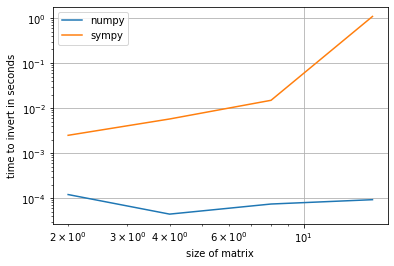

In [9]:
import time
from sympy import Matrix

N_vector = np.array([2,4,8,16])
N_inverse_sympy = np.zeros(np.size(N_vector))
N_inverse_numpy = np.zeros(np.size(N_vector))

for ix, N in enumerate(N_vector) :

    my_matrix = numpy.random.randint(low=0, high=10, size=[N,N])
    
    #time numpy
    t_start = time.time()
    np.linalg.inv(my_matrix)
    t_end = time.time()
    t_in_seconds = t_end - t_start
    N_inverse_numpy[ix] = t_in_seconds
    
    #time it
    my_sympy_matrix = Matrix(my_matrix)
    t_start = time.time()
    sympy_inverse = my_sympy_matrix.inv()
    t_end = time.time()
    t_in_seconds = t_end - t_start
    N_inverse_sympy[ix] = t_in_seconds
    
plt.loglog(N_vector, N_inverse_numpy, label='numpy')
plt.loglog(N_vector, N_inverse_sympy, label='sympy')
plt.xlabel("size of matrix")
plt.ylabel("time to invert in seconds")
plt.legend()
plt.grid()

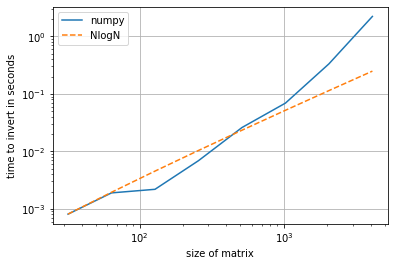

In [11]:
# Let's see how far we can go with just numpy

N_vector = np.array([32,64,128,256,512,1024,2048,4096])
N_inverse_sympy = np.zeros(np.size(N_vector))
N_inverse_numpy = np.zeros(np.size(N_vector))

for ix, N in enumerate(N_vector) :

    my_matrix = numpy.random.randint(low=0, high=10, size=[N,N])
    
    #time numpy
    t_start = time.time()
    np.linalg.inv(my_matrix)
    t_end = time.time()
    t_in_seconds = t_end - t_start
    N_inverse_numpy[ix] = t_in_seconds
    
plt.loglog(N_vector, N_inverse_numpy, label='numpy')
plt.loglog(N_vector, N_inverse_numpy[0] / (N_vector[0] * np.log(N_vector[0]))
                                        * N_vector * np.log(N_vector), '--', label='NlogN')
plt.xlabel("size of matrix")
plt.ylabel("time to invert in seconds")
plt.grid()
plt.legend()